# Decision Tree Analysis for COVID-19 Prediction
## Assignment 2A: Case Study 3 

In [3]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 172.2 kB/s  0:00:56 eta 0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 230.4 kB/s  0:00:22m0:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 210.6 kB/s  0:00:37 eta 0:00:02
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 229.9 kB/s  0:00:35 eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 230.7 kB/s  0:00:12 eta 0:00:01
Using cached joblib-1.5.3-py3-none-any.whl (309 kB)
   ━━━━━━━━

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_curve, auc, RocCurveDisplay)
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')



## Step 1: Data Loading and Preprocessing

In [2]:

print("STEP 1: DATA LOADING AND PREPROCESSING")


# Load the dataset
df = pd.read_csv('D2.csv')
print(f"\nOriginal dataset shape: {df.shape}")

# Display original data types
print("\n--- Original Data Types ---")
print(df.dtypes)

# Check for missing values
print("\n--- Missing Values Check ---")
missing = df.isnull().sum()
print(f"Total missing values: {missing.sum()}")

# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('covid19_positive')  # Remove target from features

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

STEP 1: DATA LOADING AND PREPROCESSING

Original dataset shape: (5789, 13)

--- Original Data Types ---
gender               object
age                  object
height                int64
weight                int64
blood_type           object
insurance            object
income               object
smoking              object
alcohol             float64
contacts_count      float64
working              object
worried             float64
covid19_positive      int64
dtype: object

--- Missing Values Check ---
Total missing values: 0

Categorical columns: ['gender', 'age', 'blood_type', 'insurance', 'income', 'smoking', 'working']
Numerical columns: ['height', 'weight', 'alcohol', 'contacts_count', 'worried']


In [3]:
# Preprocessing for Decision Tree Modelling
print("\n--- Data Preprocessing Steps Applied ---")

# Create a copy for processing
df_processed = df.copy()

# 1. Encode categorical variables using Label Encoding
print("\n1. Label Encoding for categorical variables:")
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    print(f"   {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")




--- Data Preprocessing Steps Applied ---

1. Label Encoding for categorical variables:
   gender: {'female': np.int64(0), 'male': np.int64(1), 'other': np.int64(2)}
   age: {'0_10': np.int64(0), '100_110': np.int64(1), '10_20': np.int64(2), '20_30': np.int64(3), '30_40': np.int64(4), '40_50': np.int64(5), '50_60': np.int64(6), '60_70': np.int64(7), '70_80': np.int64(8)}
   blood_type: {'abn': np.int64(0), 'abp': np.int64(1), 'an': np.int64(2), 'ap': np.int64(3), 'bn': np.int64(4), 'bp': np.int64(5), 'on': np.int64(6), 'op': np.int64(7), 'unknown': np.int64(8)}
   insurance: {'no': np.int64(0), 'yes': np.int64(1)}
   income: {'gov': np.int64(0), 'high': np.int64(1), 'low': np.int64(2), 'med': np.int64(3)}
   smoking: {'never': np.int64(0), 'quit0': np.int64(1), 'quit10': np.int64(2), 'quit5': np.int64(3), 'vape': np.int64(4), 'yesheavy': np.int64(5), 'yeslight': np.int64(6), 'yesmedium': np.int64(7)}
   working: {'home': np.int64(0), 'never': np.int64(1), 'stopped': np.int64(2), 'trave

## Step 2: Data Distribution (Train/Test Split)

In [4]:

print("STEP 2: DATA DISTRIBUTION - TRAIN/TEST SPLIT")


# Separate features and target
X = df_processed.drop('covid19_positive', axis=1)
y = df_processed['covid19_positive']

# Split data using stratified sampling (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n--- Distribution Split: 80% Training, 20% Testing ---")
print(f"Training set size: {len(X_train)} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"Test set size: {len(X_test)} samples ({len(X_test)/len(df)*100:.1f}%)")

print(f"\n--- Stratified Sampling Verification ---")
print(f"Training set - COVID Positive: {y_train.sum()} ({y_train.mean()*100:.1f}%)")
print(f"Test set - COVID Positive: {y_test.sum()} ({y_test.mean()*100:.1f}%)")


STEP 2: DATA DISTRIBUTION - TRAIN/TEST SPLIT

--- Distribution Split: 80% Training, 20% Testing ---
Training set size: 4631 samples (80.0%)
Test set size: 1158 samples (20.0%)

--- Stratified Sampling Verification ---
Training set - COVID Positive: 1868 (40.3%)
Test set - COVID Positive: 467 (40.3%)


## Step 3.1: Decision Tree with Default Settings

In [5]:

print("STEP 3.1: DECISION TREE WITH DEFAULT SETTINGS")


# Build default decision tree
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train, y_train)

# Predictions
y_train_pred_default = dt_default.predict(X_train)
y_test_pred_default = dt_default.predict(X_test)

# Calculate accuracies
train_acc_default = accuracy_score(y_train, y_train_pred_default)
test_acc_default = accuracy_score(y_test, y_test_pred_default)

print("\n--- Default Tree Parameters ---")
print(f"criterion: {dt_default.criterion}")
print(f"splitter: {dt_default.splitter}")
print(f"max_depth: {dt_default.max_depth} (None = unlimited)")
print(f"min_samples_split: {dt_default.min_samples_split}")
print(f"min_samples_leaf: {dt_default.min_samples_leaf}")
print(f"max_features: {dt_default.max_features}")
print(f"random_state: {dt_default.random_state}")

print("\n--- Classification Accuracy ---")
print(f"Training Accuracy: {train_acc_default*100:.2f}%")
print(f"Test Accuracy: {test_acc_default*100:.2f}%")

print("\n--- Tree Size ---")
print(f"Number of nodes: {dt_default.tree_.node_count}")
print(f"Number of leaves (rules): {dt_default.tree_.n_leaves}")
print(f"Maximum depth: {dt_default.tree_.max_depth}")

print("\n--- First Split Variable ---")
first_split_idx = dt_default.tree_.feature[0]
first_split_var = X.columns[first_split_idx]
print(f"Variable used for first split: {first_split_var}")

STEP 3.1: DECISION TREE WITH DEFAULT SETTINGS

--- Default Tree Parameters ---
criterion: gini
splitter: best
max_depth: None (None = unlimited)
min_samples_split: 2
min_samples_leaf: 1
max_features: None
random_state: 42

--- Classification Accuracy ---
Training Accuracy: 99.98%
Test Accuracy: 63.90%

--- Tree Size ---
Number of nodes: 2309
Number of leaves (rules): 1155
Maximum depth: 27

--- First Split Variable ---
Variable used for first split: income


In [6]:
print("\n--- Top 5 Important Variables ---")
feature_importance_default = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_default.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_importance_default.head(5).to_string(index=False))

print("\n--- Confusion Matrix (Test Set) ---")
cm_default = confusion_matrix(y_test, y_test_pred_default)
print(f"                  Predicted")
print(f"              Negative  Positive")
print(f"Actual Neg      {cm_default[0,0]:5d}     {cm_default[0,1]:5d}")
print(f"Actual Pos      {cm_default[1,0]:5d}     {cm_default[1,1]:5d}")

print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_test_pred_default, target_names=['Negative', 'Positive']))


--- Top 5 Important Variables ---
       Feature  Importance
        weight    0.161992
        height    0.157573
contacts_count    0.123504
        income    0.108368
       alcohol    0.084542

--- Confusion Matrix (Test Set) ---
                  Predicted
              Negative  Positive
Actual Neg        475       216
Actual Pos        202       265

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

    Negative       0.70      0.69      0.69       691
    Positive       0.55      0.57      0.56       467

    accuracy                           0.64      1158
   macro avg       0.63      0.63      0.63      1158
weighted avg       0.64      0.64      0.64      1158



## Step 3.2: Decision Tree Tuned with GridSearchCV

In [7]:

print("STEP 3.2: DECISION TREE TUNED WITH GRIDSEARCHCV")


# Define parameter grid for GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

print("\n--- GridSearchCV Parameter Grid ---")
for param, values in param_grid.items():
    print(f"{param}: {values}")

# Perform GridSearchCV with 5-fold cross-validation

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)
grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
dt_tuned = grid_search.best_estimator_

# Predictions with tuned model
y_train_pred_tuned = dt_tuned.predict(X_train)
y_test_pred_tuned = dt_tuned.predict(X_test)

# Calculate accuracies
train_acc_tuned = accuracy_score(y_train, y_train_pred_tuned)
test_acc_tuned = accuracy_score(y_test, y_test_pred_tuned)

print("\n--- Best Parameters Found ---")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nBest Cross-Validation Score: {grid_search.best_score_*100:.2f}%")

print("\n--- Classification Accuracy ---")
print(f"Training Accuracy: {train_acc_tuned*100:.2f}%")
print(f"Test Accuracy: {test_acc_tuned*100:.2f}%")

print("\n--- Tree Size ---")
print(f"Number of nodes: {dt_tuned.tree_.node_count}")
print(f"Number of leaves (rules): {dt_tuned.tree_.n_leaves}")
print(f"Maximum depth: {dt_tuned.tree_.max_depth}")

print("\n--- First Split Variable ---")
first_split_idx_tuned = dt_tuned.tree_.feature[0]
first_split_var_tuned = X.columns[first_split_idx_tuned]
print(f"Variable used for first split: {first_split_var_tuned}")

STEP 3.2: DECISION TREE TUNED WITH GRIDSEARCHCV

--- GridSearchCV Parameter Grid ---
criterion: ['gini', 'entropy']
max_depth: [3, 5, 7, 10, 15]
min_samples_split: [2, 5, 10, 20]
min_samples_leaf: [1, 2, 5, 10]
max_features: ['sqrt', 'log2', None]

--- Best Parameters Found ---
criterion: gini
max_depth: 7
max_features: None
min_samples_leaf: 2
min_samples_split: 5

Best Cross-Validation Score: 70.29%

--- Classification Accuracy ---
Training Accuracy: 75.77%
Test Accuracy: 70.38%

--- Tree Size ---
Number of nodes: 181
Number of leaves (rules): 91
Maximum depth: 7

--- First Split Variable ---
Variable used for first split: income


In [8]:
print("\n--- Top 5 Important Variables ---")
feature_importance_tuned = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_tuned.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_importance_tuned.head(5).to_string(index=False))

print("\n--- Confusion Matrix (Test Set) ---")
cm_tuned = confusion_matrix(y_test, y_test_pred_tuned)
print(f"                  Predicted")
print(f"              Negative  Positive")
print(f"Actual Neg      {cm_tuned[0,0]:5d}     {cm_tuned[0,1]:5d}")
print(f"Actual Pos      {cm_tuned[1,0]:5d}     {cm_tuned[1,1]:5d}")

print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_test_pred_tuned, target_names=['Negative', 'Positive']))


--- Top 5 Important Variables ---
       Feature  Importance
        income    0.334841
       worried    0.176308
contacts_count    0.106822
        weight    0.080781
           age    0.078254

--- Confusion Matrix (Test Set) ---
                  Predicted
              Negative  Positive
Actual Neg        519       172
Actual Pos        171       296

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

    Negative       0.75      0.75      0.75       691
    Positive       0.63      0.63      0.63       467

    accuracy                           0.70      1158
   macro avg       0.69      0.69      0.69      1158
weighted avg       0.70      0.70      0.70      1158



## Overfitting Analysis

In [9]:
print("\n--- Overfitting Analysis ---")
print(f"\nDefault Tree:")
print(f"  Training Accuracy: {train_acc_default*100:.2f}%")
print(f"  Test Accuracy: {test_acc_default*100:.2f}%")
print(f"  Difference: {(train_acc_default - test_acc_default)*100:.2f}%")
if train_acc_default - test_acc_default > 0.05:
    print("  >> Evidence of overfitting")
else:
    print("  >> No significant overfitting detected")

print(f"\nTuned Tree:")
print(f"  Training Accuracy: {train_acc_tuned*100:.2f}%")
print(f"  Test Accuracy: {test_acc_tuned*100:.2f}%")
print(f"  Difference: {(train_acc_tuned - test_acc_tuned)*100:.2f}%")
if train_acc_tuned - test_acc_tuned > 0.05:
    print("  >> Evidence of overftting")
else:
    print("  >> No significant overfitting detected")


--- Overfitting Analysis ---

Default Tree:
  Training Accuracy: 99.98%
  Test Accuracy: 63.90%
  Difference: 36.08%
  >> Evidence of overfitting

Tuned Tree:
  Training Accuracy: 75.77%
  Test Accuracy: 70.38%
  Difference: 5.39%
  >> Evidence of overftting


## Step 3.3: Model Comparison

In [10]:

print("STEP 3.3: MODEL COMPARISON")


print("\n--- Comparison Summary ---")
comparison_df = pd.DataFrame({
    'Metric': ['Training Accuracy', 'Test Accuracy', 'Number of Nodes', 
               'Number of Leaves/Rules', 'Tree Depth', 'First Split Variable'],
    'Default Tree': [f"{train_acc_default*100:.2f}%", f"{test_acc_default*100:.2f}%",
                     dt_default.tree_.node_count, dt_default.tree_.n_leaves,
                     dt_default.tree_.max_depth, first_split_var],
    'Tuned Tree (GridSearchCV)': [f"{train_acc_tuned*100:.2f}%", f"{test_acc_tuned*100:.2f}%",
                                   dt_tuned.tree_.node_count, dt_tuned.tree_.n_leaves,
                                   dt_tuned.tree_.max_depth, first_split_var_tuned]
})
print(comparison_df.to_string(index=False))

STEP 3.3: MODEL COMPARISON

--- Comparison Summary ---
                Metric Default Tree Tuned Tree (GridSearchCV)
     Training Accuracy       99.98%                    75.77%
         Test Accuracy       63.90%                    70.38%
       Number of Nodes         2309                       181
Number of Leaves/Rules         1155                        91
            Tree Depth           27                         7
  First Split Variable       income                    income


## ROC Curves

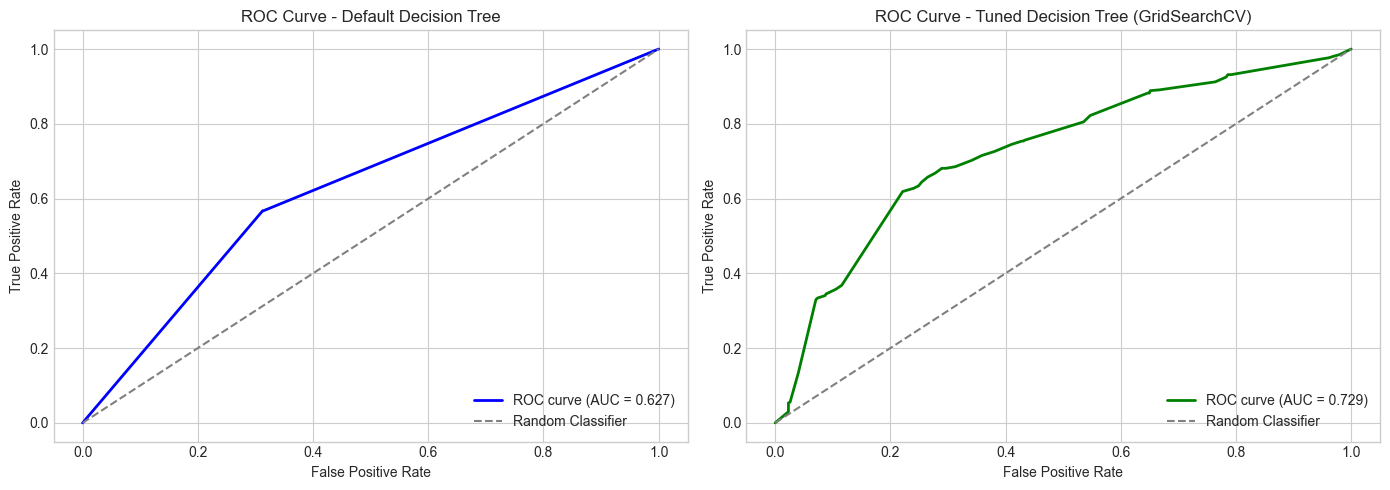

In [11]:
# Create ROC curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC for Default Tree
y_prob_default = dt_default.predict_proba(X_test)[:, 1]
fpr_default, tpr_default, _ = roc_curve(y_test, y_prob_default)
roc_auc_default = auc(fpr_default, tpr_default)

axes[0].plot(fpr_default, tpr_default, color='blue', lw=2, 
             label=f'ROC curve (AUC = {roc_auc_default:.3f})')
axes[0].plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - Default Decision Tree')
axes[0].legend(loc='lower right')
axes[0].grid(True)

# ROC for Tuned Tree
y_prob_tuned = dt_tuned.predict_proba(X_test)[:, 1]
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_prob_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

axes[1].plot(fpr_tuned, tpr_tuned, color='green', lw=2, 
             label=f'ROC curve (AUC = {roc_auc_tuned:.3f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Tuned Decision Tree (GridSearchCV)')
axes[1].legend(loc='lower right')
axes[1].grid(True)

plt.tight_layout()
plt.savefig('roc_curves_decision_trees.png', dpi=150, bbox_inches='tight')
plt.show()

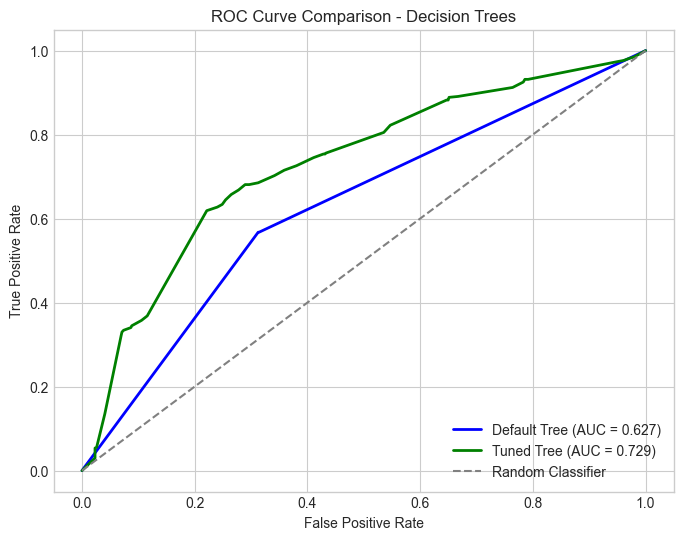


--- AUC Scores ---
Default Tree AUC: 0.6271
Tuned Tree AUC: 0.7287


In [12]:
# Combined ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_default, tpr_default, color='blue', lw=2, 
         label=f'Default Tree (AUC = {roc_auc_default:.3f})')
plt.plot(fpr_tuned, tpr_tuned, color='green', lw=2, 
         label=f'Tuned Tree (AUC = {roc_auc_tuned:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - Decision Trees')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curves_combined.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n--- AUC Scores ---")
print(f"Default Tree AUC: {roc_auc_default:.4f}")
print(f"Tuned Tree AUC: {roc_auc_tuned:.4f}")

## Step 3.4: Characteristics of COVID Positive Individuals

In [13]:

print("STEP 3.4: CHARACTERISTICS OF COVID POSITIVE INDIVIDUALS")


# Use the better model (determine which is better)
if test_acc_tuned >= test_acc_default:
    best_model = dt_tuned
    best_model_name = "Tuned Tree"
    best_importance = feature_importance_tuned
else:
    best_model = dt_default
    best_model_name = "Default Tree"
    best_importance = feature_importance_default

print(f"\nUsing the better model: {best_model_name}")

# Get decision rules from the best model
print("\n--- Decision Rules (Text Representation) ---")
tree_rules = export_text(best_model, feature_names=list(X.columns), max_depth=4)
print(tree_rules[:2000])  # Print first portion of rules

STEP 3.4: CHARACTERISTICS OF COVID POSITIVE INDIVIDUALS

Using the better model: Tuned Tree

--- Decision Rules (Text Representation) ---
|--- income <= 2.50
|   |--- insurance <= 0.50
|   |   |--- weight <= 89.00
|   |   |   |--- weight <= 45.00
|   |   |   |   |--- class: 1
|   |   |   |--- weight >  45.00
|   |   |   |   |--- contacts_count <= 19.50
|   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |--- contacts_count >  19.50
|   |   |   |   |   |--- truncated branch of depth 3
|   |   |--- weight >  89.00
|   |   |   |--- contacts_count <= 11.00
|   |   |   |   |--- age <= 5.50
|   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |--- age >  5.50
|   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |--- contacts_count >  11.00
|   |   |   |   |--- height <= 185.00
|   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |--- height >  185.00
|   |   |   |   |   |--- truncated branch of depth 2
|   |--- insurance >  0.50
| 

In [14]:
# Analyze characteristics of COVID positive individuals
print("\n--- Characteristics of COVID Positive Individuals ---")
print("\nBased on the original dataset (before encoding):")

# Use original dataframe for interpretation
covid_positive = df[df['covid19_positive'] == 1]
covid_negative = df[df['covid19_positive'] == 0]

print("\n1. Demographics:")
print(f"   Gender distribution (COVID Positive):")
print(f"   {covid_positive['gender'].value_counts(normalize=True).round(3).to_dict()}")
print(f"   Age distribution (COVID Positive):")
print(f"   {covid_positive['age'].value_counts(normalize=True).round(3).to_dict()}")

print("\n2. Behavioral Factors:")
print(f"   Smoking status (COVID Positive):")
print(f"   {covid_positive['smoking'].value_counts(normalize=True).round(3).to_dict()}")
print(f"   Working status (COVID Positive):")
print(f"   {covid_positive['working'].value_counts(normalize=True).round(3).to_dict()}")

print("\n3. Contact & Worry Level:")
print(f"   Average contacts count - Positive: {covid_positive['contacts_count'].mean():.2f}")
print(f"   Average contacts count - Negative: {covid_negative['contacts_count'].mean():.2f}")
print(f"   Average worry level - Positive: {covid_positive['worried'].mean():.2f}")
print(f"   Average worry level - Negative: {covid_negative['worried'].mean():.2f}")

print("\n4. Most Important Features for Prediction:")
print(best_importance.head(5).to_string(index=False))


--- Characteristics of COVID Positive Individuals ---

Based on the original dataset (before encoding):

1. Demographics:
   Gender distribution (COVID Positive):
   {'female': 0.504, 'male': 0.492, 'other': 0.004}
   Age distribution (COVID Positive):
   {'30_40': 0.271, '20_30': 0.217, '40_50': 0.181, '50_60': 0.158, '60_70': 0.095, '70_80': 0.037, '10_20': 0.037, '0_10': 0.003, '100_110': 0.003}

2. Behavioral Factors:
   Smoking status (COVID Positive):
   {'never': 0.615, 'quit10': 0.086, 'quit5': 0.073, 'quit0': 0.069, 'vape': 0.054, 'yesmedium': 0.048, 'yeslight': 0.036, 'yesheavy': 0.02}
   Working status (COVID Positive):
   {'travel critical': 0.309, 'stopped': 0.297, 'never': 0.239, 'travel non critical': 0.091, 'home': 0.064}

3. Contact & Worry Level:
   Average contacts count - Positive: 8.57
   Average contacts count - Negative: 7.48
   Average worry level - Positive: 3.72
   Average worry level - Negative: 3.57

4. Most Important Features for Prediction:
       Feature

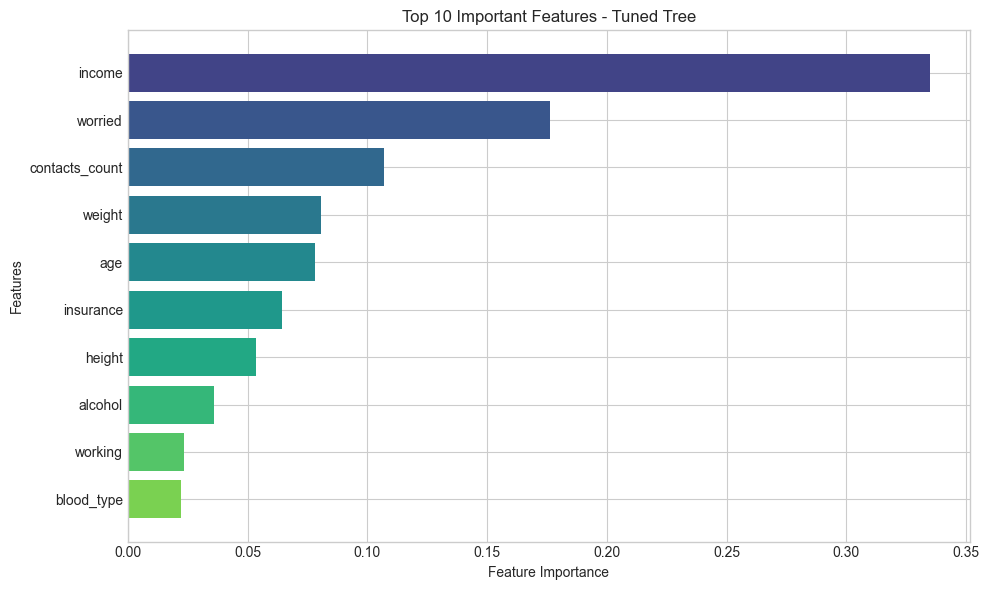

In [20]:
# Create feature importance visualization
plt.figure(figsize=(10, 6))
top_features = best_importance.head(10)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_features)))
bars = plt.barh(range(len(top_features)), top_features['Importance'].values, color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'].values)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'Top 10 Important Features - {best_model_name}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_dt.png', dpi=150, bbox_inches='tight')
plt.show()

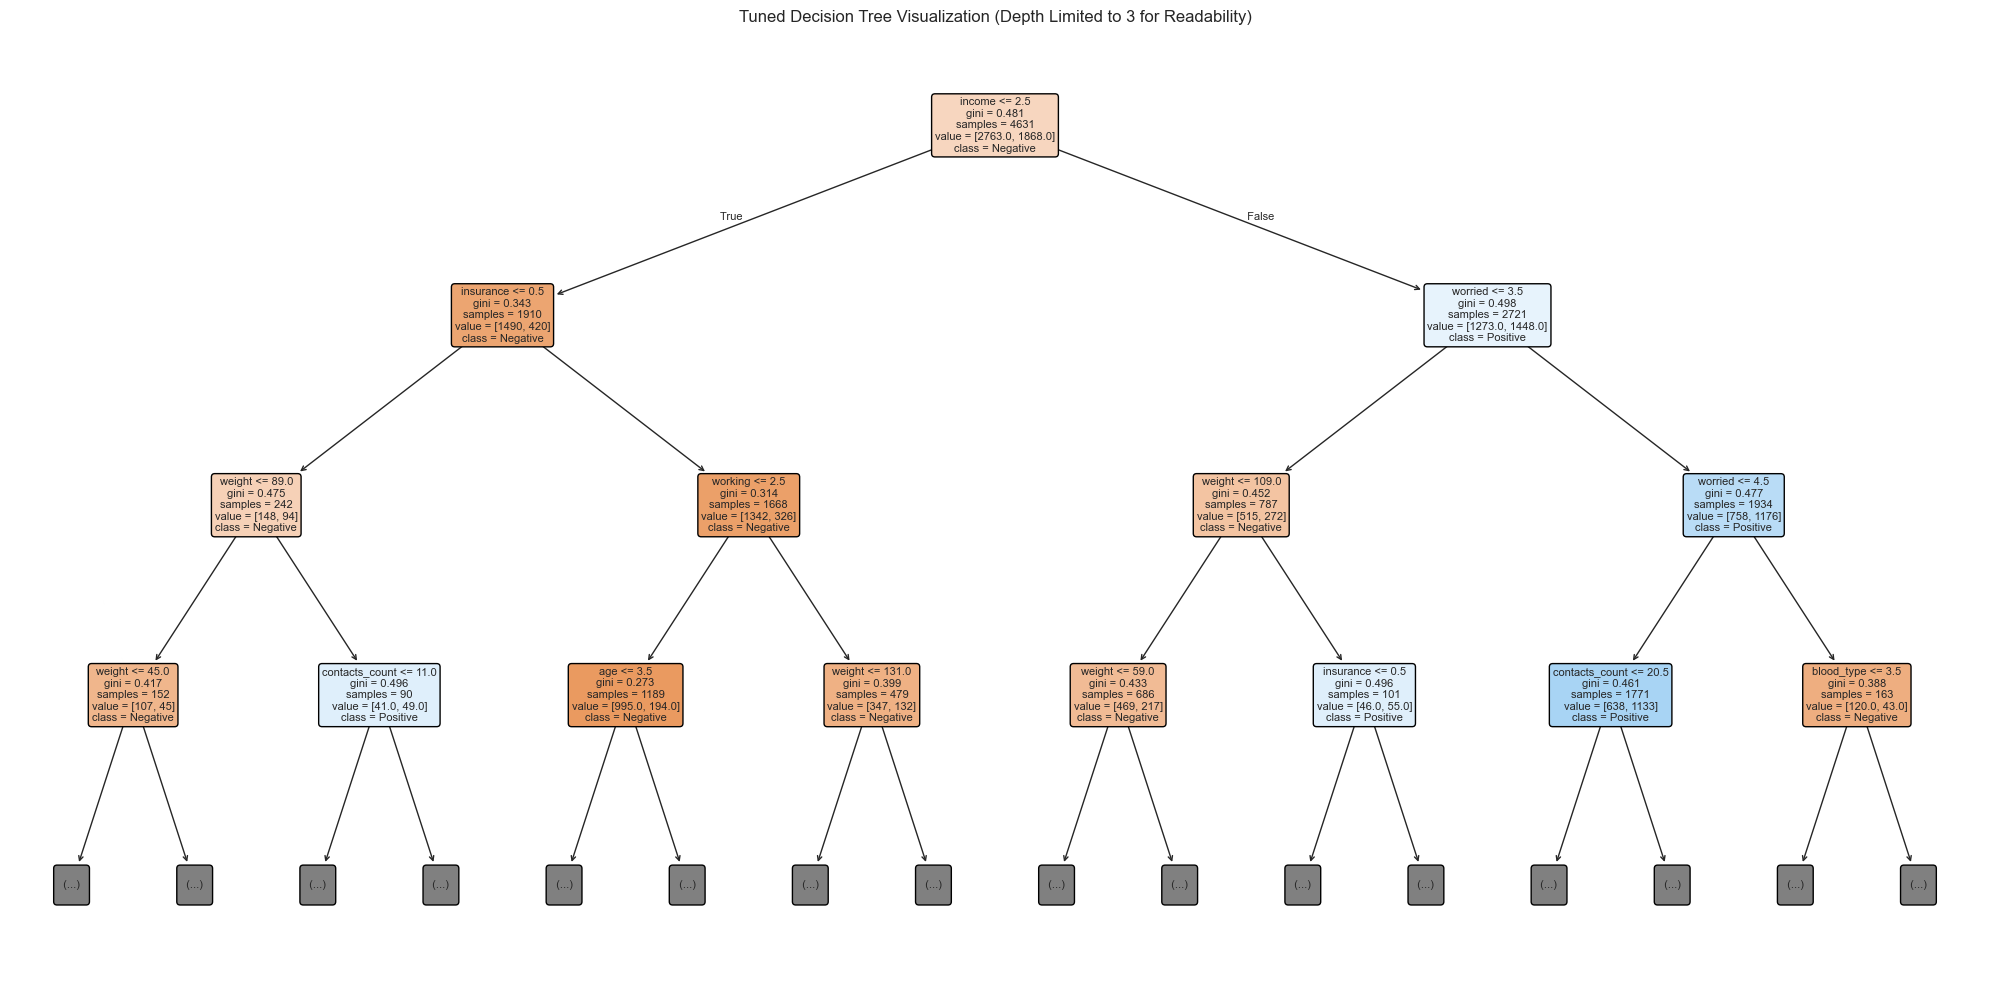

In [16]:
# Visualize the tuned decision tree (limited depth for readability)
plt.figure(figsize=(20, 10))
plot_tree(dt_tuned, feature_names=list(X.columns), class_names=['Negative', 'Positive'],
          filled=True, rounded=True, fontsize=8, max_depth=3)
plt.title('Tuned Decision Tree Visualization (Depth Limited to 3 for Readability)')
plt.tight_layout()
plt.savefig('decision_tree_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

